# PIK3CA: Effects of Hotspot Mutation on IRS2

In [23]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.stats.multitest

### Import CPTAC

In [24]:
import CPTAC

In [25]:
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

In [26]:
protein = 'IRS1'
gene = 'PIK3CA'

## Extract the data for hotspot mutations only 

In [27]:
#A list of mutations present in the hotspot according to our Hotspot3D output
hotspot_mutations = ['p.E545A', 'p.E545K', 'p.E545V', 'p.Q546P', 'p.Q546R', 'p.E542K']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Clinical_Patient_Key']

In [28]:
p10_mutations = CPTAC.compare_mutations(proteomics, protein, gene)
#print(p10_mutations)
p10_mutations['Within_Hotspot'] = False
p10_mutations.loc[hotspot_patients, 'Within_Hotspot'] = True
p10_mutations.loc[p10_mutations['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
p10_mutations = p10_mutations.loc[p10_mutations['Patient_Type'] == 'Tumor'].dropna(axis=0)
print(len(p10_mutations.loc[(p10_mutations['Within_Hotspot'] == True)]))

19


## Hotspot mutation vs non-hotspot mutation

In [29]:
in_hotspot = p10_mutations.loc[p10_mutations['Within_Hotspot'] == True]
out_hotspot = p10_mutations.loc[p10_mutations['Within_Hotspot'] == False]
ttest = scipy.stats.ttest_ind(in_hotspot[protein], out_hotspot[protein])
print(ttest)

Ttest_indResult(statistic=-0.1811143291128672, pvalue=0.8570734994915308)


## Hotspot mutation vs other mutations and wildtype

In [30]:
mutated = p10_mutations.loc[p10_mutations['Within_Hotspot'] == True]
wt = p10_mutations.loc[p10_mutations['Within_Hotspot'] != True]
ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
print(ttest)

Ttest_indResult(statistic=-0.6714134122839353, pvalue=0.5035367810301701)


## All mutations vs wildtype

In [31]:
mutated = p10_mutations.loc[p10_mutations['Within_Hotspot'] != 'Wildtype']
wt = p10_mutations.loc[p10_mutations['Within_Hotspot'] == 'Wildtype']
ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
print(ttest)

Ttest_indResult(statistic=-1.03423533120962, pvalue=0.3035716066390899)


## Hotspot mutation v wildtype

In [32]:
mutated = p10_mutations.loc[p10_mutations['Within_Hotspot'] == True]
wt = p10_mutations.loc[p10_mutations['Within_Hotspot'] == 'Wildtype']
ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
print(ttest)

Ttest_indResult(statistic=-0.890843404844897, pvalue=0.3761090199360049)


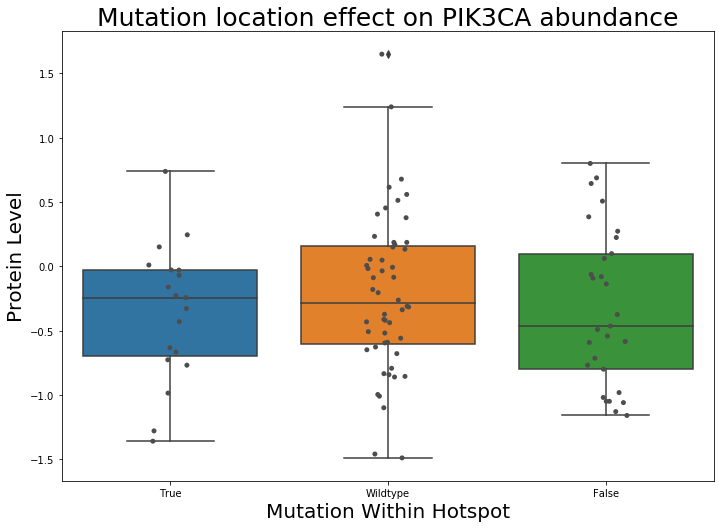

In [33]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = p10_mutations, x = 'Within_Hotspot', y = protein, ax = ax)
boxplt = sns.stripplot(data = p10_mutations, x = 'Within_Hotspot', y = protein, jitter = True, color = '.3')
boxplt.set_title('Mutation location effect on PIK3CA abundance', fontsize='25')
boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
boxplt.set_ylabel('Protein Level', fontsize='20')
plt.show()

# Phosphoproteomic Abundance

In [34]:
phos_mutations = CPTAC.compare_mutations(phos, protein, gene)
phos_mutations['Within_Hotspot'] = False
phos_mutations.loc[hotspot_patients, 'Within_Hotspot'] = True

phos_mutations.loc[phos_mutations['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
#print(phos_mutations)


phos_mutations = phos_mutations.loc[phos_mutations['Patient_Type'] == 'Tumor']
#phos_mutations = phos_mutations.dropna(axis = 0)
#print(phos_mutations)
phos_sites = list(phos_mutations)
#print(phos_sites)
phos_sites = phos_sites[:(len(phos_sites) - 3)]

## Hotspot mutation vs non-hotspot mutation

In [35]:
p_values = []
site_names = []


for site in phos_sites:
    if (site is not 'Mutation'):
        sitedf = CPTAC.compare_mutations(phos, site, gene)
        sitedf['Within_Hotspot'] = False
        sitedf.loc[sitedf, 'Within_Hotspot'] = True
            
        print(sitedf)
        sitedf.loc[sitedf['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
            
        mutateddf = sitedf.loc[sitedf['Mutation'] != 'Wildtype'].dropna(axis=0)
        wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
        ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
        p_values.append(ttest[1])
        site_names.append(site)
            
#We need to remove all 'nan' p-values and their corresponding site names before passing it in for the fdr correction
indexesToRemove=[]

for index in range(0, len(p_values)):
    if np.isnan(p_values[index]):
        indexesToRemove.append(index)

for rem in range( len(indexesToRemove)-1, -1, -1):
    p_values.pop(indexesToRemove[rem])
    site_names.pop(indexesToRemove[rem])
#p_values and site names have now had all entries removed where the corresponding p-value is 'nan'
        

pvalues = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[1]         
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[0]

significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))

print(significant_sites)
print(significant_pvalues)
print(significant_vals)

KeyError: "[('I', 'R', 'S', '1', '-', 'S', '1', '0', '0', '5')\n ('M', 'u', 't', 'a', 't', 'i', 'o', 'n')\n ('P', 'a', 't', 'i', 'e', 'n', 't', '_', 'T', 'y', 'p', 'e')\n ('W', 'i', 't', 'h', 'i', 'n', '_', 'H', 'o', 't', 's', 'p', 'o', 't')] not in index"

In [36]:
p_values = []
site_names = []


for site in phos_sites:
    mutated = phos_mutations.loc[phos_mutations['Within_Hotspot'] == True]
    
    #mutated_list = mutated[site].tolist()
    mutated_list = [x for x in mutated_list if str(x) != 'nan']
    #print(mutated_list)
    wt = phos_mutations.loc[phos_mutations['Within_Hotspot'] == False]
    wt_list = wt[site].tolist()
    wt_list = [x for x in wt_list if str(x) != 'nan']
    
    ttest = scipy.stats.ttest_ind(mutated_list, wt_list)
    p_values.append(ttest[1])
    site_names.append(site)  
    
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values)[0]
pvalues = statsmodels.stats.multitest.fdrcorrection(p_values)[1]
significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))


print(significant_sites)
print(significant_pvalues)
print(significant_vals)

[]
[]
{}


## Hotspot mutation vs other mutations and wildtype

In [37]:
p_values = []
site_names = []


for site in phos_sites:
    mutated = phos_mutations.loc[phos_mutations['Within_Hotspot'] == True]
    mutated_list = mutated[site].tolist()
    mutated_list = [x for x in mutated_list if str(x) != 'nan']
    #print(mutated_list)
    wt = phos_mutations.loc[phos_mutations['Within_Hotspot'] != True]
    wt_list = wt[site].tolist()
    wt_list = [x for x in wt_list if str(x) != 'nan']
    ttest = scipy.stats.ttest_ind(mutated_list, wt_list)
    p_values.append(ttest[1])
    site_names.append(site)  
    
    
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values)[0]
pvalues = statsmodels.stats.multitest.fdrcorrection(p_values)[1]
significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))
    
print(significant_sites)
print(significant_pvalues)
print(significant_vals)

[]
[]
{}


## All mutations vs wildtype

In [38]:
p_values = []
site_names = []

for site in phos_sites:
    mutated = phos_mutations.loc[phos_mutations['Within_Hotspot'] != 'Wildtype']
    mutated_list = mutated[site].tolist()
    mutated_list = [x for x in mutated_list if str(x) != 'nan']
    #print(mutated_list)
    wt = phos_mutations.loc[phos_mutations['Within_Hotspot'] == 'Wildtype']
    #wt_list = wt[site].tolist()
    wt_list = [x for x in wt_list if str(x) != 'nan']
    
    ttest = scipy.stats.ttest_ind(mutated_list, wt_list)
    p_values.append(ttest[1])
    site_names.append(site) 

    
sites = phos.columns
p_values = []
site_names = []
protein = 'IRS1'


pattern = re.compile(protein)
isInList = filter(pattern.search, sites)
if next(isInList, None) is not None:
    phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
    phosphositesdf['Within_Hotspot'] = False
    
    phosphositesdf.loc[hotspot_patients, 'Within_Hotspot'] = True
    print(phosphositesdf)
    phosphositesdf.loc[phosphositesdf['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
#print(phos_mutations)


    phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor']
    phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
    for site in phosphositesdf.columns:
        if (site is not 'Mutation'):
            sitedf = CPTAC.compare_mutations(phos, site, gene)
            mutateddf = sitedf.loc[sitedf['Mutation'] != 'Wildtype'].dropna(axis=0)
            wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
            ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
            p_values.append(ttest[1])
            site_names.append(site)     
                
    
#We need to remove all 'nan' p-values and their corresponding site names before passing it in for the fdr correction
indexesToRemove=[]

for index in range(0, len(p_values)):
    if np.isnan(p_values[index]):
        indexesToRemove.append(index)

for rem in range( len(indexesToRemove)-1, -1, -1):
    p_values.pop(indexesToRemove[rem])
    site_names.pop(indexesToRemove[rem])
#p_values and site names have now had all entries removed where the corresponding p-value is 'nan'
        

pvalues = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[1]         
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[0]

significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))

print(significant_sites)
print(significant_pvalues)
print(significant_vals)

      IRS1-S1005  IRS1-S1078  IRS1-S1100  IRS1-S1101  IRS1-S1131  IRS1-S1132  \
S001    -0.50100         NaN         NaN     -0.2040         NaN         NaN   
S002     0.17600         NaN     -0.3400     -0.5840         NaN         NaN   
S003     0.08390         NaN     -0.1130      0.4380         NaN         NaN   
S004     0.04480    -0.02850     -0.6880     -0.2660         NaN    -0.23100   
S005    -0.22300         NaN     -0.1900     -0.4640         NaN         NaN   
S006    -0.64900         NaN     -0.7970     -0.9885         NaN     0.47800   
S007    -0.21200         NaN      0.3930      0.8265         NaN         NaN   
S008     0.21400     0.20700     -0.2440     -0.3005         NaN         NaN   
S009     0.55400     0.79900     -0.6020     -0.2190         NaN    -0.71200   
S010    -0.08240         NaN     -0.1340      0.1505         NaN    -0.04800   
S011    -0.64400    -0.42000     -0.1270     -0.1270         NaN         NaN   
S012    -1.29000    -0.18600     -0.8270

Gene Within_Hotspot not found in phosphoproteomics data


AttributeError: 'NoneType' object has no attribute 'columns'

## Hotspot mutation v wildtype

In [ ]:
p_values = []
site_names = []


for site in phos_sites:
    mutated = phos_mutations.loc[phos_mutations['Within_Hotspot'] == True]
    mutated_list = mutated[site].tolist()
    mutated_list = [x for x in mutated_list if str(x) != 'nan']
    #print(mutated_list)
    wt = phos_mutations.loc[phos_mutations['Within_Hotspot'] == 'Wildtype']
    wt_list = wt[site].tolist()
    wt_list = [x for x in wt_list if str(x) != 'nan']
    
    ttest = scipy.stats.ttest_ind(mutated_list, wt_list)
    p_values.append(ttest[1])
    site_names.append(site) 
    
    
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values)[0]
pvalues = statsmodels.stats.multitest.fdrcorrection(p_values)[1]
significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))
    
print(significant_sites)
print(significant_pvalues)
print(significant_vals)

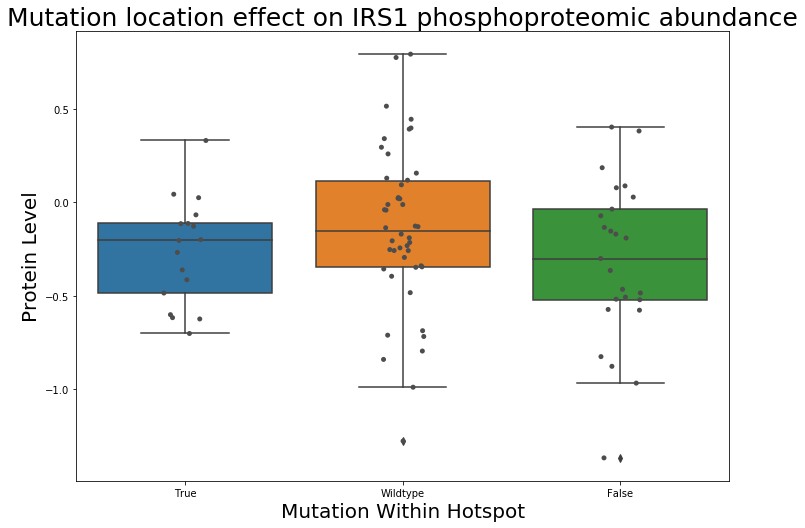

In [41]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = phos_mutations, x = 'Within_Hotspot', y = 'IRS1-S1100', ax = ax)
boxplt = sns.stripplot(data = phos_mutations, x = 'Within_Hotspot', y = 'IRS1-S1100', jitter = True, color = '.3')
boxplt.set_title('Mutation location effect on IRS1 phosphoproteomic abundance', fontsize='25')
boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
boxplt.set_ylabel('Protein Level', fontsize='20')
plt.show()

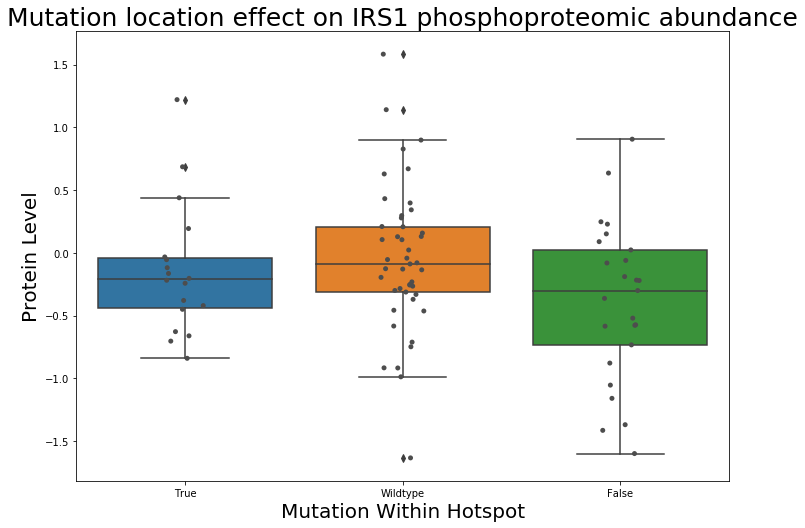

In [42]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = phos_mutations, x = 'Within_Hotspot', y = 'IRS1-S1101', ax = ax)
boxplt = sns.stripplot(data = phos_mutations, x = 'Within_Hotspot', y = 'IRS1-S1101', jitter = True, color = '.3')
boxplt.set_title('Mutation location effect on IRS1 phosphoproteomic abundance', fontsize='25')
boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
boxplt.set_ylabel('Protein Level', fontsize='20')
plt.show()

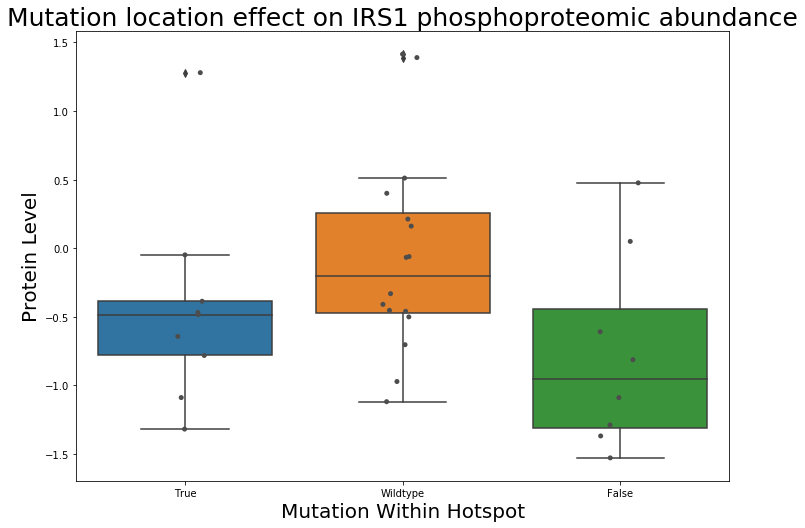

In [43]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = phos_mutations, x = 'Within_Hotspot', y = 'IRS1-S766', ax = ax)
boxplt = sns.stripplot(data = phos_mutations, x = 'Within_Hotspot', y = 'IRS1-S766', jitter = True, color = '.3')
boxplt.set_title('Mutation location effect on IRS1 phosphoproteomic abundance', fontsize='25')
boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
boxplt.set_ylabel('Protein Level', fontsize='20')
plt.show()

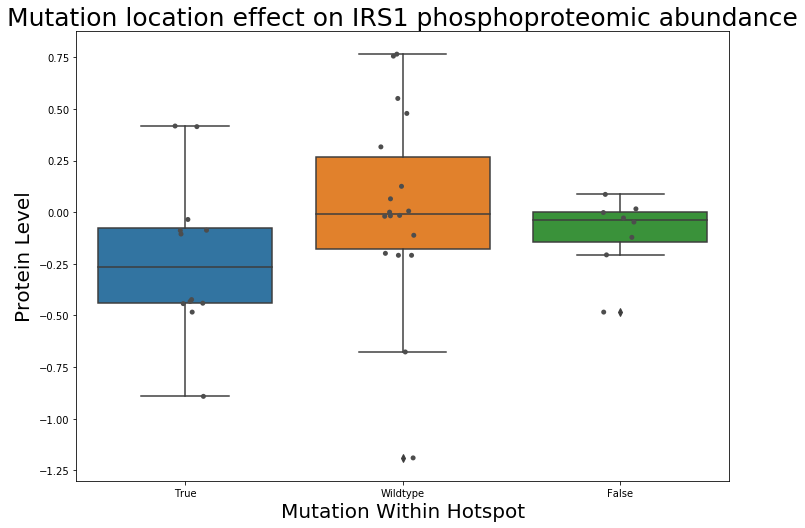

In [39]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = phos_mutations, x = 'Within_Hotspot', y = 'IRS1-S1133', ax = ax)
boxplt = sns.stripplot(data = phos_mutations, x = 'Within_Hotspot', y = 'IRS1-S1133', jitter = True, color = '.3')
boxplt.set_title('Mutation location effect on IRS1 phosphoproteomic abundance', fontsize='25')
boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
boxplt.set_ylabel('Protein Level', fontsize='20')
plt.show()

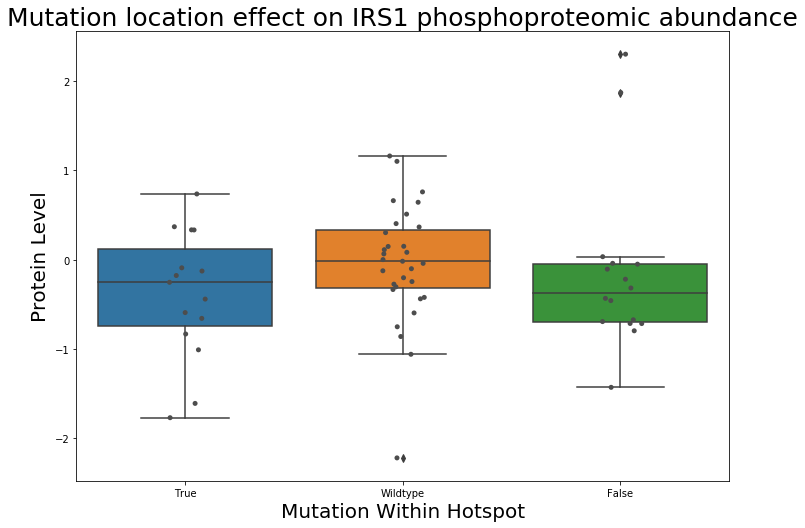

In [40]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = phos_mutations, x = 'Within_Hotspot', y = 'IRS1-S672', ax = ax)
boxplt = sns.stripplot(data = phos_mutations, x = 'Within_Hotspot', y = 'IRS1-S672', jitter = True, color = '.3')
boxplt.set_title('Mutation location effect on IRS1 phosphoproteomic abundance', fontsize='25')
boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
boxplt.set_ylabel('Protein Level', fontsize='20')
plt.show()